In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from arc.Binary_Architecture import Model
import os
from data.Data_Interface import DataInterface
from model.Model_Interface import ModelInterface
from cf.DiPACE_FA import DiPACE_FA
from cf.DiPACE_Plus import DiPACE_Plus
from eval.Evaluation import Evaluate
pd.set_option('display.max_columns', None)

/Users/jacobsanderson/Documents/DiPACE/.venv/lib/python3.9/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


In [2]:
df = pd.read_csv('datasets/diabetes.csv')

In [3]:
df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


In [4]:
X = df.drop(columns=['Outcome'])
y = df['Outcome']

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_scaled = scaler.transform(X)

In [7]:
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

In [14]:
input_size = X_train.shape[1]
model = Model(input_size)

In [15]:
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [16]:
epochs = 250
for epoch in range(epochs):
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item()}')

Epoch [10/250], Loss: 0.6530435085296631
Epoch [20/250], Loss: 0.6171627044677734
Epoch [30/250], Loss: 0.5790122151374817
Epoch [40/250], Loss: 0.5392341017723083
Epoch [50/250], Loss: 0.5026935935020447
Epoch [60/250], Loss: 0.4749937653541565
Epoch [70/250], Loss: 0.4573795795440674
Epoch [80/250], Loss: 0.44663307070732117
Epoch [90/250], Loss: 0.43894118070602417
Epoch [100/250], Loss: 0.43201225996017456
Epoch [110/250], Loss: 0.4255385398864746
Epoch [120/250], Loss: 0.41944342851638794
Epoch [130/250], Loss: 0.41338419914245605
Epoch [140/250], Loss: 0.4071507453918457
Epoch [150/250], Loss: 0.40105554461479187
Epoch [160/250], Loss: 0.39510008692741394
Epoch [170/250], Loss: 0.3892327845096588
Epoch [180/250], Loss: 0.3833244740962982
Epoch [190/250], Loss: 0.37739527225494385
Epoch [200/250], Loss: 0.3715192377567291
Epoch [210/250], Loss: 0.3655678331851959
Epoch [220/250], Loss: 0.35961779952049255
Epoch [230/250], Loss: 0.35326749086380005
Epoch [240/250], Loss: 0.34683942

In [17]:
with torch.no_grad():
    model.eval()
    outputs = model(X_test_tensor)
    predicted = (outputs >= 0.5).float()
    accuracy = (predicted == y_test_tensor).sum().item() / y_test.shape[0]
    print(f'Test Accuracy: {accuracy}')

Test Accuracy: 0.7532467532467533


In [18]:
model_path = 'pytorch_model.pth'
torch.save(model.state_dict(), model_path)

In [21]:
d = DataInterface(dataframe=df, target='Outcome', continuous_features='all')
m = ModelInterface(model_path='../DiPACE/pytorch_model.pth', input_size = input_size)

In [24]:
df = df[df['Outcome']==1]
query_index = np.random.choice(len(df))
query_instance = df.iloc[query_index].drop('Outcome').to_list()
print(query_index)

84


Desired class: tensor([1.], grad_fn=<RsubBackward1>)
Original class tensor([0.], grad_fn=<RoundBackward0>)
All CFs are classified as the desired class.
Final Loss: tensor(2.2484, grad_fn=<SubBackward0>)
Final Pred Loss: tensor(0., grad_fn=<MeanBackward0>)
Final Proximity Loss: tensor(2.9125, grad_fn=<AddBackward0>)
Final Diversity Loss: tensor(0.5738, grad_fn=<SubBackward0>)
Final Sparsity Loss: tensor(1.0725)
Final Plausibility Loss: tensor(1.9418, grad_fn=<AddBackward0>)
Unacceptably high loss. Perturbing relevant features.
All CFs are classified as the desired class.
Final Loss: tensor(2.1546, grad_fn=<SubBackward0>)
Final Pred Loss: tensor(8.7476e-05, grad_fn=<MeanBackward0>)
Final Proximity Loss: tensor(2.6459, grad_fn=<AddBackward0>)
Final Diversity Loss: tensor(0.6297, grad_fn=<SubBackward0>)
Final Sparsity Loss: tensor(1.1000)
Final Plausibility Loss: tensor(1.9950, grad_fn=<AddBackward0>)
Unacceptably high loss. Perturbing relevant features.
All CFs are classified as the desir

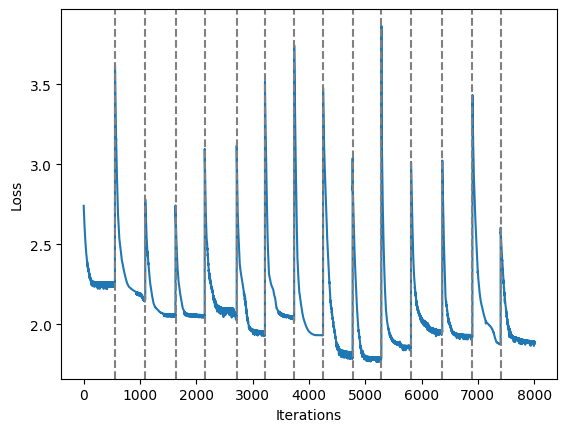

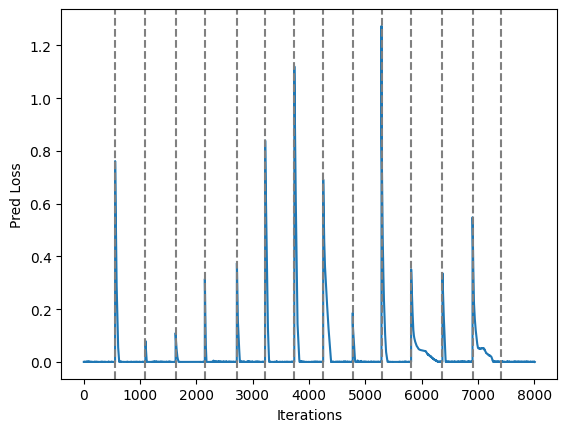

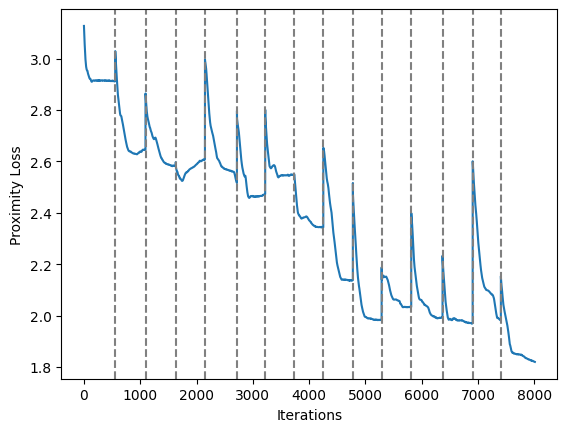

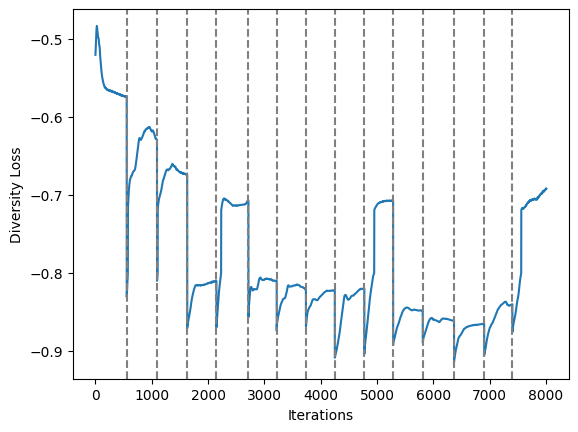

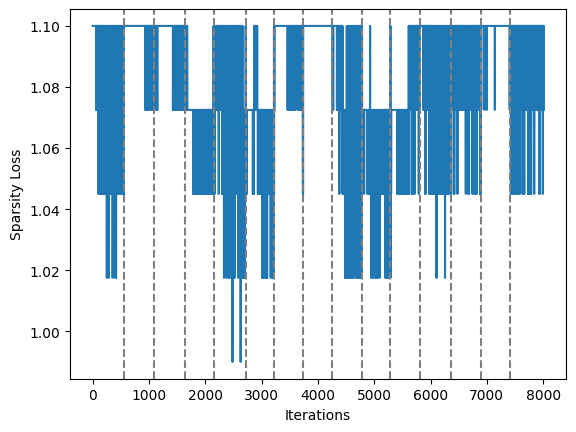

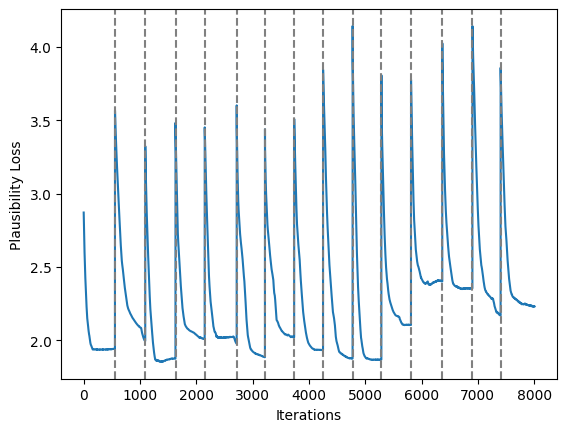

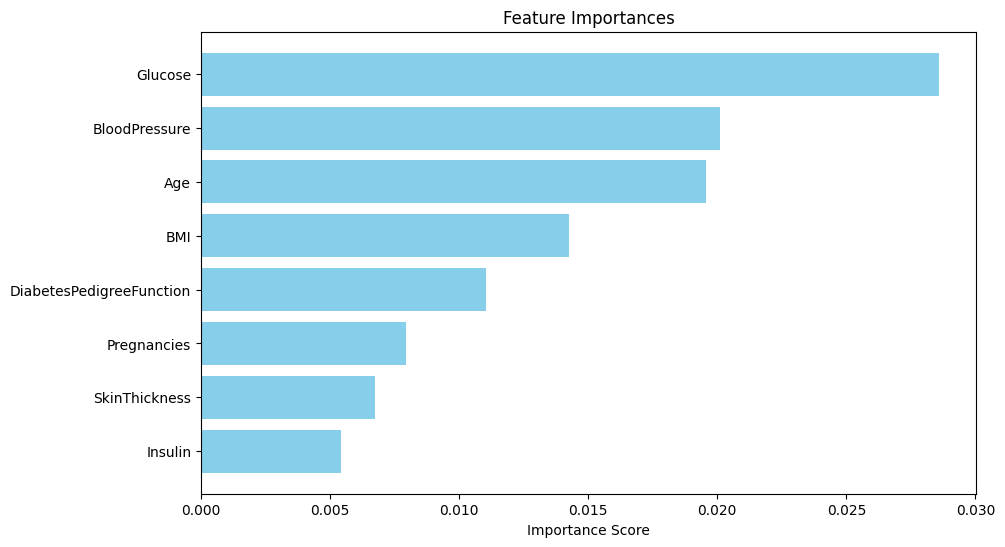

In [25]:
exp = DiPACE_FA(d, m)
cf = exp.generate_counterfactuals(query_instance, total_CFs=5, high_loss_threshold=0.7)

In [26]:
query_instance, cf_instances = cf
query_instance = torch.Tensor(query_instance).float()
cf_instances = torch.Tensor(cf_instances).float()

In [27]:
eval = Evaluate(d, m)
eval.evaluate(query_instance, cf_instances, d.norm_encoded_features, desired_class=1, k=1)

Proximity: tensor(0.7987)
Sparsity: tensor(1.)
Diversity: tensor(0.7687)
Plausibility: tensor(1.5790)
Confidence: tensor(0.7888, grad_fn=<MeanBackward0>)
